# Naive Bayes Model for Animal Outcome Prediction
Metis-Classification_Project
14JUN2022
John Tazioli

In [1]:
import pandas as pd
import numpy as np

In [2]:
#load datasets from logistic regression MVP
import pickle

with open('shelter_dogs.pickle','rb') as g:
    x = pickle.load(g)
    
with open('shelter_dogs_y.pickle', 'rb') as g:
    y = pickle.load(g)

In [3]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21989 entries, 0 to 21988
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breed_euth_rate  21989 non-null  float64
 1   age(days)        21989 non-null  int64  
 2   time_in_shelt    21989 non-null  float64
 3   Feral            21989 non-null  uint8  
 4   Injured          21989 non-null  uint8  
 5   Normal           21989 non-null  uint8  
 6   Nursing          21989 non-null  uint8  
 7   Other            21989 non-null  uint8  
 8   Pregnant         21989 non-null  uint8  
 9   Sick             21989 non-null  uint8  
dtypes: float64(2), int64(1), uint8(7)
memory usage: 665.8 KB


In [4]:
#remap adoption as 1 and euthanasia as 0
#y = y.map({'Euthanasia':0, 'Adoption':1})
#y[0:10]

## Train/Test split
70/30 split for train and test

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.3, random_state=10)

## Oversampling:
Euthanasia currently represents 6.4% of the observations. 80%/20% split or lower often causes problems. I will oversample the euthanasia observations at a ratio of 6:1 to make it 29% (6138/20507).

In [6]:
from imblearn.over_sampling import RandomOverSampler

n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)

ratio = {1:n_pos, 0:n_neg*6}

ROS = RandomOverSampler(sampling_strategy = ratio, random_state=10)

x_tr_rs, y_tr_rs = ROS.fit_resample(x_train, y_train)

In [7]:
x_tr_rs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   breed_euth_rate  20507 non-null  float64
 1   age(days)        20507 non-null  int64  
 2   time_in_shelt    20507 non-null  float64
 3   Feral            20507 non-null  uint8  
 4   Injured          20507 non-null  uint8  
 5   Normal           20507 non-null  uint8  
 6   Nursing          20507 non-null  uint8  
 7   Other            20507 non-null  uint8  
 8   Pregnant         20507 non-null  uint8  
 9   Sick             20507 non-null  uint8  
dtypes: float64(2), int64(1), uint8(7)
memory usage: 620.9 KB


In [8]:
y_tr_rs.value_counts()

1    14369
0     6138
Name: outcome_type, dtype: int64

## Naive Bayes Models:
Bernoulli NB for categorical condition dummy variables and Gaussian NB for breed euth rate, age, and time in shelter 

In [9]:
#split features into 2 dataframes
x_tr_gaus = x_tr_rs.iloc[:,0:3]
x_tr_bern = x_tr_rs.iloc[:,3:]

x_tst_g = x_test.iloc[:,0:3]
x_tst_b = x_test.iloc[:,3:] 

### Gaussian NB

In [10]:
from sklearn.naive_bayes import GaussianNB

g_nb = GaussianNB()

g_nb.fit(x_tr_gaus, y_tr_rs)

y_g_pred = g_nb.predict(x_tst_g)

y_g_pred = pd.Series(y_g_pred)

In [11]:
from sklearn.metrics import f1_score

print(f"F1: {f1_score(y_test, y_g_pred)}")

F1: 0.9461087593617714


In [13]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_g_pred)

array([[ 124,  264],
       [ 398, 5811]])

In [26]:
print(g_nb.theta_)

[[1.37559949e-01 1.41068019e+03 1.41475580e+01]
 [5.87998124e-02 7.02135918e+02 2.47642061e+01]]


Euthanized dogs: 1410 days old on average, 14 days in shelter
Adopted dogs: 702 days old on average, 24 days in shelter

### Bernoulli NB

In [15]:
from sklearn.naive_bayes import BernoulliNB

b_nb = BernoulliNB()

b_nb.fit(x_tr_bern, y_tr_rs)

y_b_pred = b_nb.predict(x_tst_b)

In [16]:
print(f"F1: {f1_score(y_test, y_b_pred)}")

F1: 0.9503419081732334


In [17]:
confusion_matrix(y_test,y_b_pred)

array([[ 150,  238],
       [ 372, 5837]])

feature_log_prob_ will return the log probability of each feature being 1 for the given class - 0=adoption, 1=euthanasia.

In [33]:
log_prob_bern = b_nb.feature_log_prob_
adopt_prob_bern = []
euth_prob_bern = []

for each in log_prob_bern[0]:
    adopt_prob_bern.append(np.exp(each))
    
for each in log_prob_bern[1]:
    euth_prob_bern.append(np.exp(each))

In [34]:
print(adopt_prob_bern)

[0.0001628664495114005, 0.24201954397394118, 0.6368078175895762, 0.01140065146579804, 0.005863192182410418, 0.0001628664495114005, 0.09055374592833867]


In [35]:
print(euth_prob_bern)

[0.00020875374017117787, 0.02679006332196785, 0.9470461345765776, 0.011342286549300671, 0.0014612761811982453, 0.0008350149606847116, 0.010507271588615958]


94% of euthanized outcomes had a normal status, 2.6% had injured, Nursing and Sick at 1% each

## Ensemble with Voting Classifier

In [51]:
from sklearn.ensemble import VotingClassifier

model_list = [('gnb',g_nb),
             ('bnb',b_nb)]

vc = VotingClassifier(estimators = model_list,
                     voting = 'hard',
                     weights = None)

vc.fit(x_tr_rs,y_tr_rs)

vc_y_pred = vc.predict(x_test)

In [52]:
print(f"F1: {f1_score(y_test, vc_y_pred)}")

F1: 0.9455592105263159


In [53]:
confusion_matrix(y_test,vc_y_pred)

array([[ 186,  202],
       [ 460, 5749]])

In [54]:
vc_soft = VotingClassifier(estimators = model_list,
                     voting = 'soft',
                     weights = [1,1])

vc_soft.fit(x_tr_rs,y_tr_rs)

vc_soft_y_pred = vc_soft.predict(x_test)

## Probability Bar Plot

In [55]:
import matplotlib.pyplot as plt

In [58]:
prob = [c.fit(x_tr_rs,y_tr_rs).predict_proba(x_test) for c in (g_nb, b_nb, vc_soft)]

In [59]:
class0 = [pr[0,0] for pr in prob]
class1 = [pr[0,1] for pr in prob]

In [65]:
print(class0)
print(class1)

[0.0031932613490641467, 0.19798551757975064, 0.10058938946440739]
[0.9968067386509359, 0.8020144824202494, 0.8994106105355927]


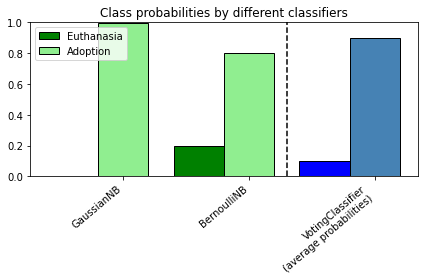

In [67]:
n = 3
ind = np.arange(n)
width = 0.4

fig, ax = plt.subplots()

#bars for bern and gaussian nb
p1 = ax.bar(ind, np.hstack(([class0[:-1], [0]])), width, color="green", edgecolor="k")
p2 = ax.bar(
    ind + width,
    np.hstack(([class1[:-1], [0]])),
    width,
    color="lightgreen",
    edgecolor="k",
)

# bars for VotingClassifier
p3 = ax.bar(ind, [0, 0, class0[-1]], width, color="blue", edgecolor="k")
p4 = ax.bar(
    ind + width, [0, 0, class1[-1]], width, color="steelblue", edgecolor="k"
)

# plot annotations
plt.axvline(1.7, color="k", linestyle="dashed")
ax.set_xticks(ind + width)
ax.set_xticklabels(
    [
        "GaussianNB",
        "BernoulliNB",
        "VotingClassifier\n(average probabilities)",
    ],
    rotation=40,
    ha="right",
)
plt.ylim([0, 1])
plt.title("Class probabilities by different classifiers")
plt.legend([p1[0], p2[0]], ["Euthanasia", "Adoption"], loc="upper left")
plt.tight_layout()

plt.savefig('class_prob.jpg')

#https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_probas.html for guidance creating the graph